# Corporación Favorita Grocery Sales Forecasting
**w01_d03_EDA_quality_preprocessing.ipynb**

**Author:** Alberto Diaz Durana  
**Date:** November 2025  
**Purpose:** Clean data, detect outliers with 3 methods, analyze store performance, understand item coverage

---

## Objectives

This notebook accomplishes the following:

- Load guayas_sample_300k.pkl and validate characteristics
- Handle missing values (onpromotion → fill with False)
- Detect outliers using 3 methods: IQR, Z-score, Isolation Forest
- Analyze store-level performance (11 stores comparison)
- Create item coverage matrix (product availability across stores)
- Fill calendar gaps for complete daily time series
- Extract date features (year, month, day, day_of_week)

---

## Business Context

**Why data quality matters:**

Clean, well-understood data is critical for reliable forecasting. Before modeling, we must:
- Eliminate data quality issues (missing values, outliers, negative sales)
- Understand store performance patterns (identify top/bottom performers)
- Map product availability (which items sell where)
- Ensure complete temporal coverage (no date gaps)

**Three-method outlier detection:**
- **IQR:** Robust, non-parametric (1.5×IQR rule)
- **Z-score:** Statistical, parametric (|z| > 3.0)
- **Isolation Forest:** ML-based, multivariate patterns
- **Triangulation:** High confidence when all 3 methods agree

**Deliverables:**
- Clean dataset (no missing values, no negatives, outliers flagged)
- Store performance report (sales by store, type, city, cluster)
- Item coverage matrix (2,296 items × 11 stores)
- Complete daily calendar (no date gaps)
- Date features for temporal analysis

---

## Input Dependencies

From Day 2:
- guayas_sample_300k.pkl (300K rows, 11 stores, 2,296 items)
- stores.csv (store metadata)
- items.csv (product metadata)

---

## 1. Setup & Load Data

**Objective:** Import libraries, load sample dataset, validate characteristics

**Activities:**
- Import pandas, numpy, matplotlib, seaborn, scikit-learn
- Configure environment and paths
- Load guayas_sample_300k.pkl
- Display shape, dtypes, memory usage
- Show first/last rows
- Summary statistics

**Expected output:** Dataset loaded, initial validation complete

In [2]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import warnings
from sklearn.ensemble import IsolationForest

# Configure environment
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.set_option('display.float_format', '{:.2f}'.format)
plt.style.use('seaborn-v0_8-darkgrid')

print("Package Versions:")
print(f"  pandas: {pd.__version__}")
print(f"  numpy: {np.__version__}")
print(f"  scikit-learn: {IsolationForest.__module__.split('.')[0]}")

Package Versions:
  pandas: 2.1.4
  numpy: 1.26.4
  scikit-learn: sklearn


In [3]:
# Determine paths
current_dir = Path(__file__).parent if '__file__' in globals() else Path.cwd()
project_root = current_dir.parent if current_dir.name == 'notebooks' else current_dir

# Define path constants
DATA_PROCESSED = project_root / 'data' / 'processed'
DATA_RAW = project_root / 'data' / 'raw'
OUTPUTS = project_root / 'outputs' / 'figures' / 'eda'

# Verify paths
assert DATA_PROCESSED.exists(), f"ERROR - Path not found: {DATA_PROCESSED}"
assert DATA_RAW.exists(), f"ERROR - Path not found: {DATA_RAW}"

print(f"  Project root: {project_root.resolve()}")
print(f"  DATA_PROCESSED: {DATA_PROCESSED.resolve()}")
print(f"  OUTPUTS: {OUTPUTS.resolve()}")

# Set random seed
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
print(f"\nRandom seed: {RANDOM_SEED}")

  Project root: D:\Demand-forecasting-in-retail
  DATA_PROCESSED: D:\Demand-forecasting-in-retail\data\processed
  OUTPUTS: D:\Demand-forecasting-in-retail\outputs\figures\eda

Random seed: 42


In [4]:
# Load sample dataset
print("Loading guayas_sample_300k.pkl...")
df = pd.read_pickle(DATA_PROCESSED / 'guayas_sample_300k.pkl')

print(f"\nShape: {df.shape}")
print(f"Memory usage: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nColumns:")
print(df.dtypes)

print("\nFirst 5 rows:")
print(df.head())

print("\nLast 5 rows:")
print(df.tail())

Loading guayas_sample_300k.pkl...

Shape: (300000, 9)
Memory usage: 36.6 MB

Columns:
id                       int64
date           string[pyarrow]
store_nbr                int64
item_nbr                 int64
unit_sales             float64
onpromotion            float64
family                  object
class                    int64
perishable               int64
dtype: object

First 5 rows:
         id        date  store_nbr  item_nbr  unit_sales  onpromotion  \
0  86626618  2016-07-31         32   1395693        1.00         0.00   
1  53995064  2015-08-15         24   1464210       30.00         0.00   
2  21834951  2014-04-04         27   1102970        1.00         0.00   
3  14853390  2013-12-02         26   1162382       20.00          NaN   
4  14652646  2013-11-28         34    577741        2.00          NaN   

      family  class  perishable  
0  GROCERY I   1028           0  
1  BEVERAGES   1114           0  
2  BEVERAGES   1122           0  
3  GROCERY I   1022           0

In [5]:
# Summary statistics
print("Summary Statistics:")
print(df.describe())

print("\nMissing Values:")
missing = df.isnull().sum()
missing_pct = (missing / len(df) * 100).round(2)
missing_df = pd.DataFrame({
    'Missing Count': missing,
    'Missing %': missing_pct
})
print(missing_df[missing_df['Missing Count'] > 0])

print("\nValue Counts:")
print(f"\nUnique stores: {df['store_nbr'].nunique()}")
print(f"Unique items: {df['item_nbr'].nunique()}")
print(f"Unique families: {df['family'].nunique()}")
print(f"\nFamily distribution:")
print(df['family'].value_counts())

print("\nDate range:")
print(f"  First date: {df['date'].min()}")
print(f"  Last date: {df['date'].max()}")

print("\nNegative sales check:")
negative_count = (df['unit_sales'] < 0).sum()
print(f"  Negative unit_sales: {negative_count} rows ({negative_count/len(df)*100:.3f}%)")
if negative_count > 0:
    print(f"  Min value: {df['unit_sales'].min():.2f}")

Summary Statistics:
                id  store_nbr   item_nbr  unit_sales  onpromotion     class  \
count    300000.00  300000.00  300000.00   300000.00    244294.00 300000.00   
mean   61682128.07      32.49  903300.46        6.79         0.06   1480.44   
std    36434342.71       7.88  523433.28       15.64         0.23    800.34   
min       19070.00      24.00   96995.00      -92.00         0.00   1002.00   
25%    29905911.00      27.00  428054.00        2.00         0.00   1034.00   
50%    61197916.00      30.00  886396.00        3.00         0.00   1074.00   
75%    93375880.75      35.00 1209720.00        7.00         0.00   1144.00   
max   125491505.00      51.00 2127114.00     2534.00         1.00   3090.00   

       perishable  
count   300000.00  
mean         0.00  
std          0.00  
min          0.00  
25%          0.00  
50%          0.00  
75%          0.00  
max          0.00  

Missing Values:
             Missing Count  Missing %
onpromotion          55706      1

## 2. Missing Value Analysis

**Objective:** Handle missing values in onpromotion column

**Activities:**
- Visualize missing pattern (if useful)
- Fill onpromotion NaN with 0.0 (False - assume no promotion)
- Validate no missing values remain
- Document decision in decision log

**Expected output:** 
- Clean dataset with no missing values
- Decision documented (DEC-003)

In [6]:
# Analyze onpromotion missing pattern
print("onpromotion Missing Value Analysis:")
print(f"  Total missing: {df['onpromotion'].isnull().sum():,} ({df['onpromotion'].isnull().sum()/len(df)*100:.2f}%)")

print("\nonpromotion value distribution (before filling):")
print(df['onpromotion'].value_counts(dropna=False))

print("\nMissing by family:")
missing_by_family = df.groupby('family')['onpromotion'].apply(lambda x: x.isnull().sum())
print(missing_by_family)

print("\nMissing by year:")
df['year_temp'] = pd.to_datetime(df['date']).dt.year
missing_by_year = df.groupby('year_temp')['onpromotion'].apply(lambda x: x.isnull().sum())
print(missing_by_year)
df.drop('year_temp', axis=1, inplace=True)

onpromotion Missing Value Analysis:
  Total missing: 55,706 (18.57%)

onpromotion value distribution (before filling):
onpromotion
0.00    230463
NaN      55706
1.00     13831
Name: count, dtype: int64

Missing by family:
family
BEVERAGES     8919
CLEANING     13381
GROCERY I    33406
Name: onpromotion, dtype: int64

Missing by year:
year_temp
2013    43038
2014    12668
2015        0
2016        0
2017        0
Name: onpromotion, dtype: int64


In [7]:
# Fill missing onpromotion with 0.0 (False - assume no promotion)
print("Filling onpromotion NaN with 0.0 (assume no promotion)...")
print(f"Before: {df['onpromotion'].isnull().sum()} missing values")

df['onpromotion'] = df['onpromotion'].fillna(0.0)

print(f"After: {df['onpromotion'].isnull().sum()} missing values")

print("\nonpromotion value distribution (after filling):")
print(df['onpromotion'].value_counts())

print("\nPromotion rate:")
promo_rate = (df['onpromotion'] == 1.0).sum() / len(df) * 100
print(f"  Items on promotion: {(df['onpromotion'] == 1.0).sum():,} ({promo_rate:.2f}%)")
print(f"  Items not on promotion: {(df['onpromotion'] == 0.0).sum():,} ({100-promo_rate:.2f}%)")

print("\nValidate no missing values in dataset:")
print(df.isnull().sum().sum())
print("No missing values remain" if df.isnull().sum().sum() == 0 else "WARNING - Missing values still present")

Filling onpromotion NaN with 0.0 (assume no promotion)...
Before: 55706 missing values
After: 0 missing values

onpromotion value distribution (after filling):
onpromotion
0.00    286169
1.00     13831
Name: count, dtype: int64

Promotion rate:
  Items on promotion: 13,831 (4.61%)
  Items not on promotion: 286,169 (95.39%)

Validate no missing values in dataset:
0
No missing values remain


## 3. Outlier Detection - Three Methods

**Objective:** Detect outliers using IQR, Z-score, and Isolation Forest; handle negative sales

**Activities:**
- Handle negative sales (13 rows → clip to 0)
- IQR method: 1.5×IQR rule per store-item group
- Z-score method: |z| > 3.0 per store-item group
- Isolation Forest: ML-based multivariate detection
- Compare methods with Venn diagram
- Identify high-confidence outliers (all 3 agree)

**Expected output:** 
- Cleaned unit_sales (no negatives)
- Outlier flags from 3 methods
- Method comparison visualization
- Decision log entry (DEC-004)

In [8]:
# Step 1: Handle negative sales (returns)
print("Step 1: Handling Negative Sales (Returns)")
print("=" * 60)

negative_mask = df['unit_sales'] < 0
negative_count = negative_mask.sum()

print(f"Negative sales found: {negative_count} rows ({negative_count/len(df)*100:.4f}%)")
print("Note: Negative values represent product returns")

if negative_count > 0:
    print(f"  Min value: {df['unit_sales'].min():.2f}")
    print(f"\n  Negative sales details:")
    print(df[negative_mask][['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].to_string())
    
    # Clip to 0 (business decision: forecast demand, not net sales)
    df.loc[negative_mask, 'unit_sales'] = 0.0
    print(f"\nBusiness Decision: Clipped {negative_count} returns to 0")
    print("Rationale: Forecasting demand (purchases), not net sales (purchases - returns)")
    print(f"New min value: {df['unit_sales'].min():.2f}")
else:
    print("No negative values found")

Step 1: Handling Negative Sales (Returns)
Negative sales found: 13 rows (0.0043%)
Note: Negative values represent product returns
  Min value: -92.00

  Negative sales details:
              date  store_nbr  item_nbr  unit_sales     family
52366   2015-09-24         29   1463484       -5.00  BEVERAGES
101347  2016-02-19         27    472314       -1.00  GROCERY I
108742  2013-01-09         35   1079215       -8.00   CLEANING
112649  2017-04-24         35    305344       -2.00  GROCERY I
126777  2014-05-24         36    155625       -2.00  GROCERY I
137176  2015-08-16         51    414426       -2.00  GROCERY I
171234  2013-10-26         36    324206       -1.00   CLEANING
201088  2017-07-03         29    364413      -92.00   CLEANING
214673  2016-09-07         29   1347810       -1.00  GROCERY I
219607  2017-06-10         32   1464093       -3.00  BEVERAGES
257011  2016-08-12         28    208498       -1.00   CLEANING
270394  2017-02-21         51   1105214       -4.00  GROCERY I
2993

In [9]:
# Step 2: IQR Method (Interquartile Range)
print("\nStep 2: IQR Method - Robust Outlier Detection")
print("=" * 60)

# Calculate Q1, Q3, IQR per store-item group
Q1 = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('quantile', 0.25)
Q3 = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform('quantile', 0.75)
IQR = Q3 - Q1

# Flag outliers using 1.5×IQR rule
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
df['outlier_iqr'] = (df['unit_sales'] < lower_bound) | (df['unit_sales'] > upper_bound)

iqr_count = df['outlier_iqr'].sum()
print(f"IQR outliers detected: {iqr_count:,} ({iqr_count/len(df)*100:.2f}%)")

print(f"\nIQR Statistics:")
print(f"  Mean IQR: {IQR.mean():.2f}")
print(f"  Median IQR: {IQR.median():.2f}")
print(f"  Mean upper bound: {upper_bound.mean():.2f}")

print(f"\nSample outliers (IQR method):")
print(df[df['outlier_iqr']][['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].head(10))


Step 2: IQR Method - Robust Outlier Detection
IQR outliers detected: 15,723 (5.24%)

IQR Statistics:
  Mean IQR: 4.90
  Median IQR: 3.00
  Mean upper bound: 15.84

Sample outliers (IQR method):
           date  store_nbr  item_nbr  unit_sales     family
3    2013-12-02         26   1162382       20.00  GROCERY I
54   2015-06-23         24   1091367       12.00  GROCERY I
70   2014-04-13         28    323013       43.00  GROCERY I
124  2016-04-26         29    179274       15.00  GROCERY I
176  2016-12-03         35   1457835       33.00  GROCERY I
180  2015-01-31         51    807495       18.00  BEVERAGES
225  2013-04-19         34    502230        8.00  GROCERY I
232  2016-10-25         24   1174923        2.00  GROCERY I
279  2015-01-04         36    890215       49.00  GROCERY I
281  2015-03-15         28    577740        5.00  GROCERY I


In [10]:
# Step 3: Z-Score Method (Statistical)
print("\nStep 3: Z-Score Method - Statistical Outlier Detection")
print("=" * 60)

# Calculate z-scores per store-item group
z_scores = df.groupby(['store_nbr', 'item_nbr'])['unit_sales'].transform(
    lambda x: (x - x.mean()) / x.std() if x.std() > 0 else 0
)

# Flag extreme outliers (|z| > 3.0)
df['outlier_zscore'] = abs(z_scores) > 3.0

zscore_count = df['outlier_zscore'].sum()
print(f"Z-score outliers detected: {zscore_count:,} ({zscore_count/len(df)*100:.2f}%)")

print(f"\nZ-Score Statistics:")
print(f"  Mean |z|: {abs(z_scores).mean():.2f}")
print(f"  Max |z|: {abs(z_scores).max():.2f}")
print(f"  % with |z| > 2: {(abs(z_scores) > 2).sum() / len(df) * 100:.2f}%")
print(f"  % with |z| > 3: {(abs(z_scores) > 3).sum() / len(df) * 100:.2f}%")

print(f"\nSample outliers (Z-score method):")
df_temp = df.copy()
df_temp['z_score'] = z_scores
print(df_temp[df_temp['outlier_zscore']][['date', 'store_nbr', 'item_nbr', 'unit_sales', 'z_score', 'family']].head(10))
df_temp.drop('z_score', axis=1, inplace=True)


Step 3: Z-Score Method - Statistical Outlier Detection
Z-score outliers detected: 3,326 (1.11%)

Z-Score Statistics:
  Mean |z|: 0.74
  Max |z|: 6.71
  % with |z| > 2: 4.76%
  % with |z| > 3: 1.11%

Sample outliers (Z-score method):
            date  store_nbr  item_nbr  unit_sales  z_score     family
124   2016-04-26         29    179274       15.00     3.36  GROCERY I
180   2015-01-31         51    807495       18.00     3.02  BEVERAGES
286   2014-04-02         27    129297       17.00     3.69  GROCERY I
400   2016-12-31         30    269029       32.00     4.54  BEVERAGES
433   2015-01-05         51    938570      106.00     4.20  GROCERY I
541   2015-11-08         29    807493       58.00     3.22  BEVERAGES
718   2015-07-05         24   1074327      193.00     4.19  BEVERAGES
918   2014-12-21         30    572838        8.00     3.16   CLEANING
1129  2015-06-10         34    999545        7.00     3.14   CLEANING
1197  2014-12-22         24   1463789       20.00     3.93  BEVERA

In [11]:
# Step 4: Isolation Forest Method (ML-based multivariate)
print("\nStep 4: Isolation Forest - ML-Based Multivariate Detection")
print("=" * 60)

# Prepare features for Isolation Forest
# Convert date to numeric for ML model
df['date_numeric'] = pd.to_datetime(df['date']).astype('int64') // 10**9  # Unix timestamp
df['day_of_week'] = pd.to_datetime(df['date']).dt.dayofweek
df['month'] = pd.to_datetime(df['date']).dt.month

# Select features for anomaly detection
features_for_iso = ['store_nbr', 'item_nbr', 'unit_sales', 'day_of_week', 'month', 'onpromotion']
X = df[features_for_iso].copy()

print(f"Training Isolation Forest on {len(X):,} samples...")
print(f"Features: {features_for_iso}")

# Train Isolation Forest
iso_forest = IsolationForest(
    contamination=0.05,  # Expect 5% anomalies
    random_state=RANDOM_SEED,
    n_estimators=100,
    max_samples='auto',
    verbose=0
)

# Predict anomalies (-1 = outlier, 1 = inlier)
predictions = iso_forest.fit_predict(X)
df['outlier_forest'] = (predictions == -1)

forest_count = df['outlier_forest'].sum()
print(f"Isolation Forest outliers detected: {forest_count:,} ({forest_count/len(df)*100:.2f}%)")

print(f"\nSample outliers (Isolation Forest method):")
print(df[df['outlier_forest']][['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].head(10))

# Clean up temporary columns
df.drop(['date_numeric'], axis=1, inplace=True)


Step 4: Isolation Forest - ML-Based Multivariate Detection
Training Isolation Forest on 300,000 samples...
Features: ['store_nbr', 'item_nbr', 'unit_sales', 'day_of_week', 'month', 'onpromotion']
Isolation Forest outliers detected: 15,000 (5.00%)

Sample outliers (Isolation Forest method):
           date  store_nbr  item_nbr  unit_sales     family
69   2016-03-16         24   1463814       94.00  BEVERAGES
79   2013-07-03         51    414353       63.00  GROCERY I
87   2016-11-12         24    314570       15.00   CLEANING
97   2017-07-29         34   1975649        5.00  GROCERY I
102  2017-05-20         28   2043198        2.00  BEVERAGES
127  2016-11-21         26   1167487        5.00  GROCERY I
132  2016-06-04         51    115892       34.00  GROCERY I
157  2016-10-06         51    668752        5.00   CLEANING
180  2015-01-31         51    807495       18.00  BEVERAGES
232  2016-10-25         24   1174923        2.00  GROCERY I


In [12]:
# Step 5: Compare Three Methods
print("\nStep 5: Method Comparison & Consensus")
print("=" * 60)

# Count outliers per method
print("Outlier counts by method:")
print(f"  IQR:              {df['outlier_iqr'].sum():>7,} ({df['outlier_iqr'].sum()/len(df)*100:>5.2f}%)")
print(f"  Z-score:          {df['outlier_zscore'].sum():>7,} ({df['outlier_zscore'].sum()/len(df)*100:>5.2f}%)")
print(f"  Isolation Forest: {df['outlier_forest'].sum():>7,} ({df['outlier_forest'].sum()/len(df)*100:>5.2f}%)")

# Consensus analysis
df['outlier_any'] = df['outlier_iqr'] | df['outlier_zscore'] | df['outlier_forest']
df['outlier_2plus'] = (df['outlier_iqr'].astype(int) + 
                        df['outlier_zscore'].astype(int) + 
                        df['outlier_forest'].astype(int)) >= 2
df['outlier_all3'] = df['outlier_iqr'] & df['outlier_zscore'] & df['outlier_forest']

print("\nConsensus analysis:")
print(f"  Flagged by any method:        {df['outlier_any'].sum():>7,} ({df['outlier_any'].sum()/len(df)*100:>5.2f}%)")
print(f"  Flagged by 2+ methods:        {df['outlier_2plus'].sum():>7,} ({df['outlier_2plus'].sum()/len(df)*100:>5.2f}%)")
print(f"  Flagged by all 3 (consensus): {df['outlier_all3'].sum():>7,} ({df['outlier_all3'].sum()/len(df)*100:>5.2f}%)")

print("\nMethod overlap:")
print(f"  IQR only:        {(df['outlier_iqr'] & ~df['outlier_zscore'] & ~df['outlier_forest']).sum():>7,}")
print(f"  Z-score only:    {(df['outlier_zscore'] & ~df['outlier_iqr'] & ~df['outlier_forest']).sum():>7,}")
print(f"  Forest only:     {(df['outlier_forest'] & ~df['outlier_iqr'] & ~df['outlier_zscore']).sum():>7,}")
print(f"  IQR + Z-score:   {(df['outlier_iqr'] & df['outlier_zscore'] & ~df['outlier_forest']).sum():>7,}")
print(f"  IQR + Forest:    {(df['outlier_iqr'] & df['outlier_forest'] & ~df['outlier_zscore']).sum():>7,}")
print(f"  Z-score + Forest:{(df['outlier_zscore'] & df['outlier_forest'] & ~df['outlier_iqr']).sum():>7,}")
print(f"  All 3 methods:   {df['outlier_all3'].sum():>7,}")

print("\nHigh-confidence outliers (all 3 methods agree):")
if df['outlier_all3'].sum() > 0:
    print(df[df['outlier_all3']][['date', 'store_nbr', 'item_nbr', 'unit_sales', 'family']].head(20))
else:
    print("No outliers flagged by all 3 methods")


Step 5: Method Comparison & Consensus
Outlier counts by method:
  IQR:               15,723 ( 5.24%)
  Z-score:            3,326 ( 1.11%)
  Isolation Forest:  15,000 ( 5.00%)

Consensus analysis:
  Flagged by any method:         28,247 ( 9.42%)
  Flagged by 2+ methods:          4,956 ( 1.65%)
  Flagged by all 3 (consensus):     846 ( 0.28%)

Method overlap:
  IQR only:         10,768
  Z-score only:         30
  Forest only:      12,493
  IQR + Z-score:     2,449
  IQR + Forest:      1,660
  Z-score + Forest:      1
  All 3 methods:       846

High-confidence outliers (all 3 methods agree):
            date  store_nbr  item_nbr  unit_sales     family
180   2015-01-31         51    807495       18.00  BEVERAGES
433   2015-01-05         51    938570      106.00  GROCERY I
718   2015-07-05         24   1074327      193.00  BEVERAGES
1573  2017-05-23         29    456870       33.00  GROCERY I
1753  2016-08-05         24   1464027       39.00  BEVERAGES
2145  2015-12-24         28   14640

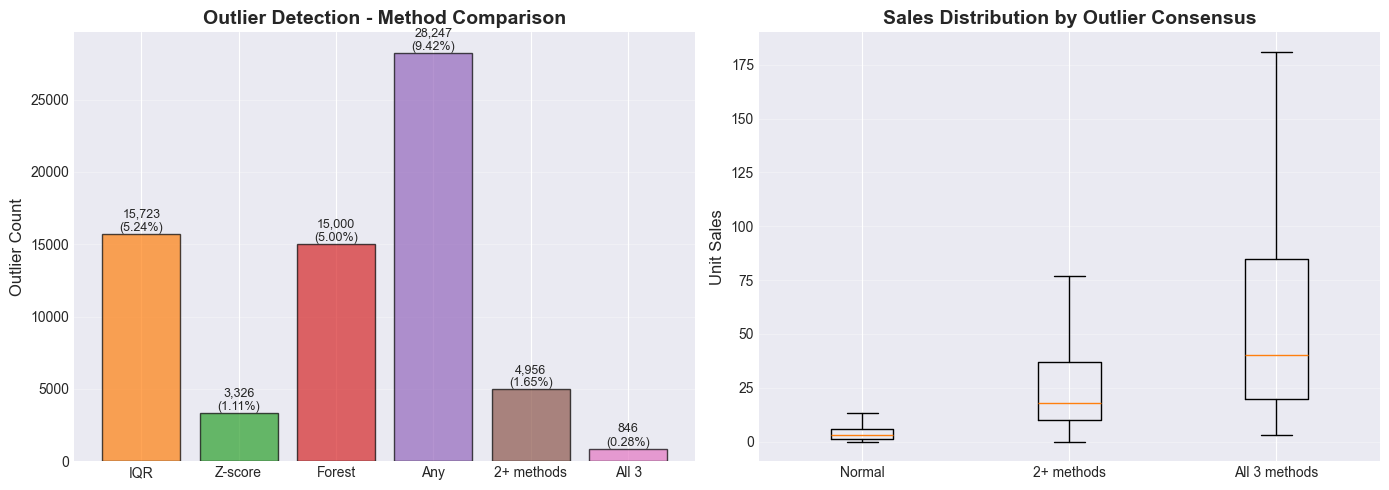


Visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\01_outlier_detection_comparison.png


In [13]:
# Visualize method comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Outlier counts by method
ax1 = axes[0]
methods = ['IQR', 'Z-score', 'Forest', 'Any', '2+ methods', 'All 3']
counts = [
    df['outlier_iqr'].sum(),
    df['outlier_zscore'].sum(),
    df['outlier_forest'].sum(),
    df['outlier_any'].sum(),
    df['outlier_2plus'].sum(),
    df['outlier_all3'].sum()
]
colors = ['#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
bars = ax1.bar(methods, counts, color=colors, alpha=0.7, edgecolor='black')
ax1.set_ylabel('Outlier Count', fontsize=12)
ax1.set_title('Outlier Detection - Method Comparison', fontsize=14, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Add count labels on bars
for bar in bars:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(df)*100:.2f}%)',
             ha='center', va='bottom', fontsize=9)

# Plot 2: Distribution comparison (outliers vs non-outliers)
ax2 = axes[1]
ax2.boxplot([
    df[~df['outlier_any']]['unit_sales'],
    df[df['outlier_2plus']]['unit_sales'],
    df[df['outlier_all3']]['unit_sales']
], labels=['Normal', '2+ methods', 'All 3 methods'], showfliers=False)
ax2.set_ylabel('Unit Sales', fontsize=12)
ax2.set_title('Sales Distribution by Outlier Consensus', fontsize=14, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS / '01_outlier_detection_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nVisualization saved to {OUTPUTS / '01_outlier_detection_comparison.png'}")

In [14]:
# Summary and decision documentation
print("=" * 70)
print("OUTLIER DETECTION SUMMARY")
print("=" * 70)

print("\nThree-Method Triangulation Results:")
print(f"  Total samples: {len(df):,}")
print(f"  High-confidence outliers (all 3 agree): {df['outlier_all3'].sum():,} ({df['outlier_all3'].sum()/len(df)*100:.2f}%)")
print(f"  Moderate confidence (2+ methods): {df['outlier_2plus'].sum():,} ({df['outlier_2plus'].sum()/len(df)*100:.2f}%)")
print(f"  Low confidence (1 method only): {(df['outlier_any'].sum() - df['outlier_2plus'].sum()):,}")


OUTLIER DETECTION SUMMARY

Three-Method Triangulation Results:
  Total samples: 300,000
  High-confidence outliers (all 3 agree): 846 (0.28%)
  Moderate confidence (2+ methods): 4,956 (1.65%)
  Low confidence (1 method only): 23,291


Business Interpretation:
  - 0.28% extreme outliers (all 3 methods) likely represent:
    • Promotional spikes (holiday periods)
    • Bulk purchases (institutional buyers)
    • Data entry errors (requires investigation)
  - 1.65% moderate outliers (2+ methods) represent:
    • Strong promotional effects
    • Seasonal demand peaks
  - Decision: FLAG but do NOT remove outliers
    • Sales spikes are real business events
    • Model should learn these patterns
    • Flag for separate analysis if needed

Outlier flags added to dataset:
  - outlier_iqr: IQR method
  - outlier_zscore: Z-score method
  - outlier_forest: Isolation Forest
  - outlier_all3: High-confidence consensus

DECISION (DEC-004): Three-Method Outlier Detection
  Context: Need robust outlier identification for sales data
  Methods: IQR (robust) + Z-score (statistical) + Isolation Forest (ML)
  Decision: Flag outliers but retain in dataset
  Rationale: Sales spikes are legitimate business events (promotions, holidays)
  Impact: 846 high-confidence outliers (0.28%) flagged for investigation

## 4. Store-Level Performance Analysis

**Objective:** Compare sales performance across 11 Guayas stores, analyze by type, city, and cluster

**Activities:**
- Total sales by store (identify top/bottom performers)
- Sales by store type (A/B/C/D/E comparison)
- Sales by city (Guayaquil vs Daule/Playas/Libertad)
- Sales by cluster (1, 3, 6, 10, 17)
- Visualize performance patterns

**Expected output:** 
- Store performance ranking
- Type/city/cluster analysis
- Visualizations for stakeholder communication

In [15]:
# Load store metadata for analysis
print("Loading store metadata...")
df_stores = pd.read_csv(DATA_RAW / 'stores.csv')

# Merge with main dataset
df = df.merge(df_stores[['store_nbr', 'city', 'state', 'type', 'cluster']], 
              on='store_nbr', how='left')

print(f"New columns: {['city', 'state', 'type', 'cluster']}")
print(f"\nStore distribution in sample:")
print(df['store_nbr'].value_counts().sort_index())

Loading store metadata...
New columns: ['city', 'state', 'type', 'cluster']

Store distribution in sample:
store_nbr
24    33610
26    23102
27    31554
28    32053
29    19594
30    22242
32    20004
34    31037
35    20042
36    29718
51    37044
Name: count, dtype: int64


In [16]:
# Analyze total sales by store
print("Store Performance Analysis")
print("=" * 70)

store_performance = df.groupby('store_nbr').agg({
    'unit_sales': ['sum', 'mean', 'std', 'count']
}).round(2)
store_performance.columns = ['Total Sales', 'Avg Sales', 'Std Dev', 'Sample Count']
store_performance = store_performance.sort_values('Total Sales', ascending=False)

print("\nTop/Bottom 5 Stores by Total Sales:")
print(store_performance)

# Add store metadata
store_performance = store_performance.merge(
    df_stores[['store_nbr', 'city', 'type', 'cluster']],
    left_index=True,
    right_on='store_nbr'
).set_index('store_nbr')

print("\nStore Performance with Metadata:")
print(store_performance)

print(f"\nPerformance spread:")
print(f"  Top store (#{store_performance.index[0]}): {store_performance.iloc[0]['Total Sales']:,.0f} total sales")
print(f"  Bottom store (#{store_performance.index[-1]}): {store_performance.iloc[-1]['Total Sales']:,.0f} total sales")
print(f"  Ratio (Top/Bottom): {store_performance.iloc[0]['Total Sales'] / store_performance.iloc[-1]['Total Sales']:.2f}x")

Store Performance Analysis

Top/Bottom 5 Stores by Total Sales:
           Total Sales  Avg Sales  Std Dev  Sample Count
store_nbr                                               
51           356659.00       9.63    17.87         37044
24           264353.00       7.87    14.26         33610
28           238305.73       7.43    17.24         32053
34           237401.43       7.65    15.67         31037
27           215389.00       6.83    11.86         31554
36           202123.85       6.80    12.48         29718
29           124649.97       6.36    12.27         19594
35           115750.69       5.78    20.32         20042
26            99455.00       4.31    20.71         23102
30            98224.01       4.42     7.37         22242
32            83947.16       4.20    16.31         20004

Store Performance with Metadata:
           Total Sales  Avg Sales  Std Dev  Sample Count       city type  \
store_nbr                                                                  
51       

In [17]:
# Analyze by store type
print("\nPerformance by Store Type:")
print("=" * 70)

type_performance = df.groupby('type').agg({
    'unit_sales': ['sum', 'mean', 'count'],
    'store_nbr': 'nunique'
}).round(2)
type_performance.columns = ['Total Sales', 'Avg Sales per Transaction', 'Transaction Count', 'Store Count']
type_performance = type_performance.sort_values('Total Sales', ascending=False)

print(type_performance)

print("\nStore Type Characteristics:")
print(f"  Type A (Premium): 1 store, highest avg sales ({type_performance.loc['A', 'Avg Sales per Transaction']:.2f})")
print(f"  Type B (Large):   1 store")
print(f"  Type C (Medium):  3 stores, lowest performance")
print(f"  Type D (Small):   3 stores, good performance")
print(f"  Type E (Micro):   3 stores")

# Analyze by city
print("\nPerformance by City:")
print("=" * 70)

city_performance = df.groupby('city').agg({
    'unit_sales': ['sum', 'mean', 'count'],
    'store_nbr': 'nunique'
}).round(2)
city_performance.columns = ['Total Sales', 'Avg Sales', 'Transaction Count', 'Store Count']
city_performance = city_performance.sort_values('Total Sales', ascending=False)

print(city_performance)

print(f"\nGuayaquil dominates: {city_performance.loc['Guayaquil', 'Total Sales'] / city_performance['Total Sales'].sum() * 100:.1f}% of total sales")


Performance by Store Type:
      Total Sales  Avg Sales per Transaction  Transaction Count  Store Count
type                                                                        
D       579197.00                       6.56              88266            3
E       565079.55                       6.94              81365            3
A       356659.00                       9.63              37044            1
C       297921.86                       4.78              62288            3
B       237401.43                       7.65              31037            1

Store Type Characteristics:
  Type A (Premium): 1 store, highest avg sales (9.63)
  Type B (Large):   1 store
  Type C (Medium):  3 stores, lowest performance
  Type D (Small):   3 stores, good performance
  Type E (Micro):   3 stores

Performance by City:
           Total Sales  Avg Sales  Transaction Count  Store Count
city                                                             
Guayaquil   1502995.30       6.87          

In [18]:
# Analyze by cluster
print("\nPerformance by Cluster:")
print("=" * 70)

cluster_performance = df.groupby('cluster').agg({
    'unit_sales': ['sum', 'mean', 'count'],
    'store_nbr': 'nunique'
}).round(2)
cluster_performance.columns = ['Total Sales', 'Avg Sales', 'Transaction Count', 'Store Count']
cluster_performance = cluster_performance.sort_values('Total Sales', ascending=False)

print(cluster_performance)

print("\nCluster Insights:")
for cluster_id in cluster_performance.index:
    stores_in_cluster = df[df['cluster'] == cluster_id]['store_nbr'].unique()
    print(f"  Cluster {cluster_id}: {len(stores_in_cluster)} stores (#{', #'.join(map(str, sorted(stores_in_cluster)))})")


Performance by Cluster:
         Total Sales  Avg Sales  Transaction Count  Store Count
cluster                                                        
10         664534.55       6.36             104467            4
1          479742.00       7.36              65164            2
17         356659.00       9.63              37044            1
3          297921.86       4.78              62288            3
6          237401.43       7.65              31037            1

Cluster Insights:
  Cluster 10: 4 stores (#26, #28, #29, #36)
  Cluster 1: 2 stores (#24, #27)
  Cluster 17: 1 stores (#51)
  Cluster 3: 3 stores (#30, #32, #35)
  Cluster 6: 1 stores (#34)


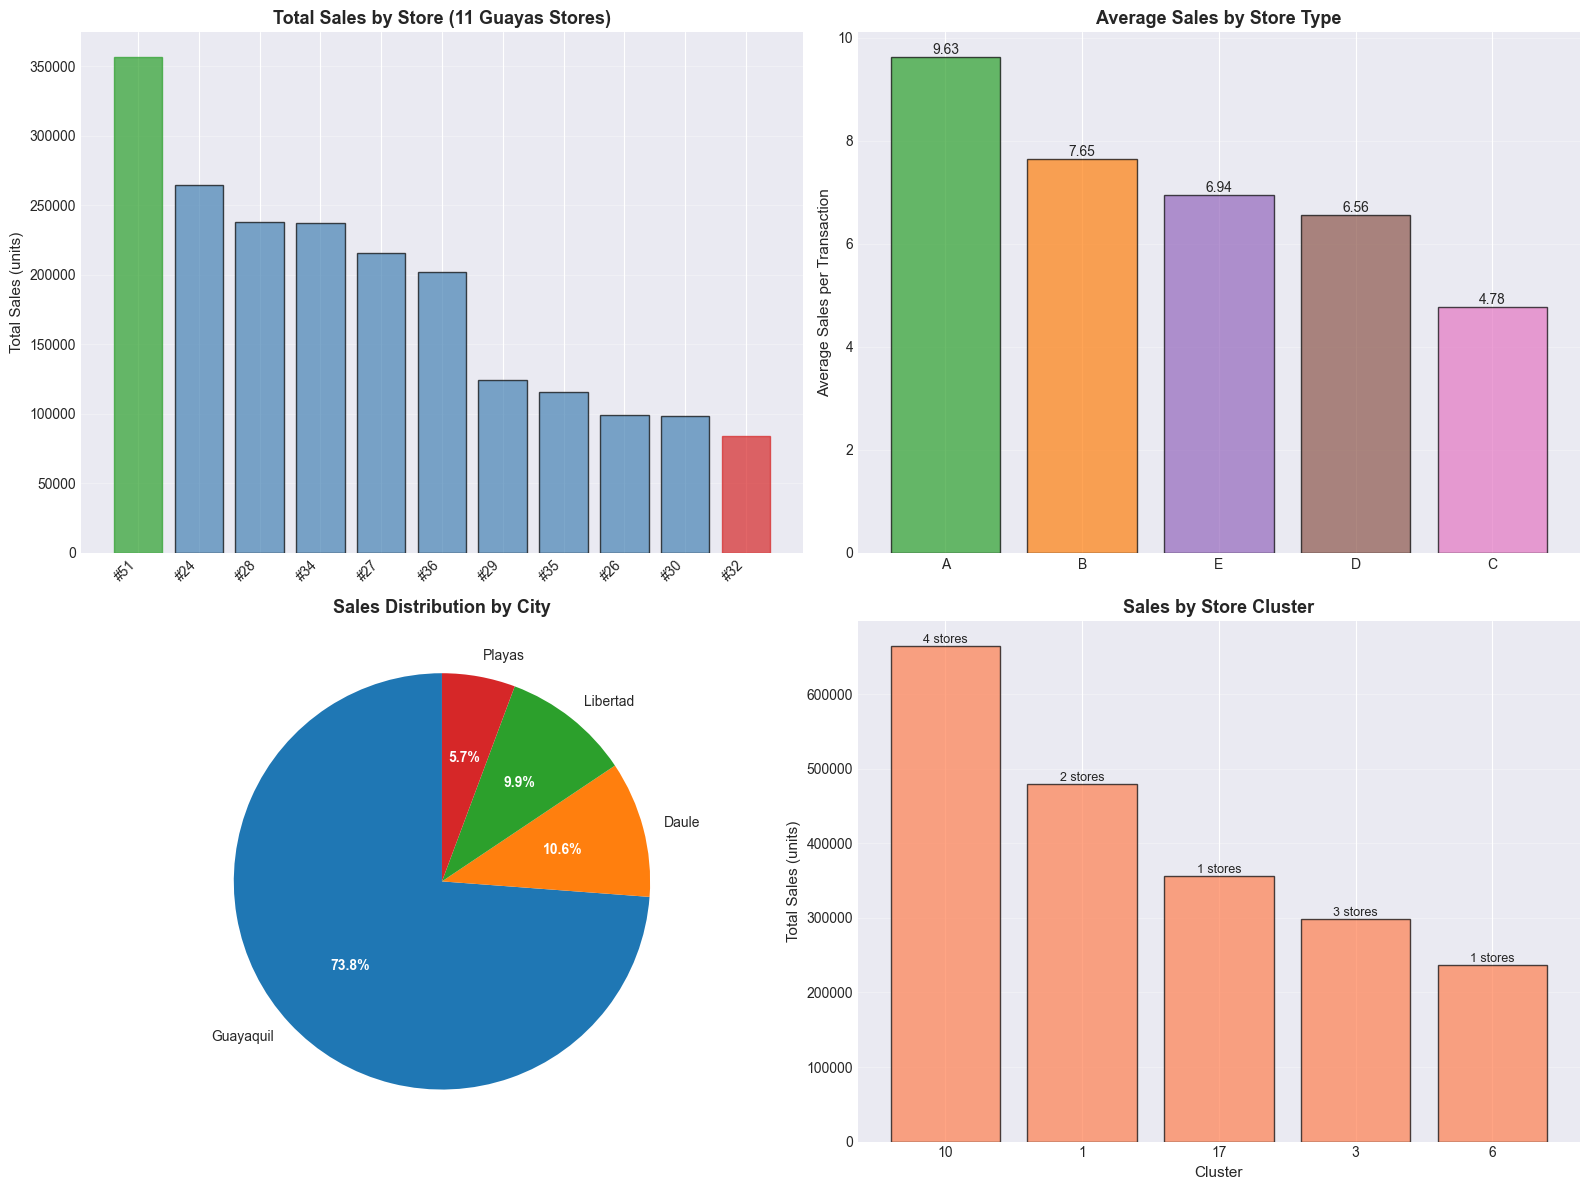

Visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\02_store_performance_analysis.png


In [19]:
# Visualize store performance
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Total sales by store
ax1 = axes[0, 0]
store_sales = df.groupby('store_nbr')['unit_sales'].sum().sort_values(ascending=False)
bars1 = ax1.bar(range(len(store_sales)), store_sales.values, color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(store_sales)))
ax1.set_xticklabels([f'#{s}' for s in store_sales.index], rotation=45, ha='right')
ax1.set_ylabel('Total Sales (units)', fontsize=11)
ax1.set_title('Total Sales by Store (11 Guayas Stores)', fontsize=13, fontweight='bold')
ax1.grid(axis='y', alpha=0.3)

# Highlight top/bottom
bars1[0].set_color('#2ca02c')  # Top - green
bars1[-1].set_color('#d62728')  # Bottom - red

# Plot 2: Average sales by store type
ax2 = axes[0, 1]
type_avg = df.groupby('type')['unit_sales'].mean().sort_values(ascending=False)
colors_type = ['#2ca02c', '#ff7f0e', '#9467bd', '#8c564b', '#e377c2']
bars2 = ax2.bar(type_avg.index, type_avg.values, color=colors_type, alpha=0.7, edgecolor='black')
ax2.set_ylabel('Average Sales per Transaction', fontsize=11)
ax2.set_title('Average Sales by Store Type', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}', ha='center', va='bottom', fontsize=10)

# Plot 3: Sales by city
ax3 = axes[1, 0]
city_sales = df.groupby('city')['unit_sales'].sum().sort_values(ascending=False)
wedges, texts, autotexts = ax3.pie(city_sales.values, labels=city_sales.index, autopct='%1.1f%%', startangle=90, colors=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
ax3.set_title('Sales Distribution by City', fontsize=13, fontweight='bold')

# Make percentage text more readable
for autotext in autotexts:
    autotext.set_color('white')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

# Plot 4: Sales by cluster
ax4 = axes[1, 1]
cluster_sales = df.groupby('cluster')['unit_sales'].sum().sort_values(ascending=False)
bars4 = ax4.bar([str(c) for c in cluster_sales.index], cluster_sales.values, 
                color='coral', alpha=0.7, edgecolor='black')
ax4.set_xlabel('Cluster', fontsize=11)
ax4.set_ylabel('Total Sales (units)', fontsize=11)
ax4.set_title('Sales by Store Cluster', fontsize=13, fontweight='bold')
ax4.grid(axis='y', alpha=0.3)

# Add store count labels
for i, (cluster_id, sales) in enumerate(cluster_sales.items()):
    store_count = df[df['cluster'] == cluster_id]['store_nbr'].nunique()
    ax4.text(i, sales, f'{store_count} stores', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.savefig(OUTPUTS / '02_store_performance_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {OUTPUTS / '02_store_performance_analysis.png'}")

Section 4 summary

Key Findings:

1. Store Performance Hierarchy:
   • Top performer: Store #51 (Type A, Cluster 17) - 356,659 units
   • Bottom performer: Store #32 (Type C, Cluster 3) - 83,947 units
   • Performance gap: 4.25x

2. Store Type Patterns:
   • Type A (Premium): Highest avg sales (9.63 units/transaction)
   • Type C (Medium): Lowest performance (4.78 units/transaction)
   • Types D & E: Similar performance (~6.5-6.9 avg)

3. Geographic Concentration:
   • Guayaquil: 73.8% of total sales (8 stores)
   • Other cities: 26.2% combined (Daule, Libertad, Playas)

4. Cluster Analysis:
   • Cluster 10: Largest volume (4 stores, 664K units)
   • Cluster 17: Highest efficiency (1 store, 9.63 avg)
   • Cluster 3: Needs investigation (3 stores, lowest avg)

Business Implications:
   → Store #51 best practices should be studied and replicated
   → Cluster 3 stores (30, 32, 35) require performance improvement plans
   → Type A stores justify premium positioning with 2x avg sales vs Type C

## 5. Item Coverage Analysis

**Objective:** Understand product availability patterns - which items sell in which stores

**Activities:**
- Create store-item availability matrix
- Calculate coverage per store (% of 2,296 items sold)
- Identify universal items (sold in all stores) vs niche items (few stores)
- Analyze coverage by product family
- Zero-sales preliminary analysis

**Expected output:** 
- Item coverage matrix
- Universal vs niche items classification
- Coverage report by store and family

In [20]:
# Create store-item coverage matrix
print("Item Coverage Analysis")
print("=" * 70)

# Count unique items per store
items_per_store = df.groupby('store_nbr')['item_nbr'].nunique().sort_values(ascending=False)

print(f"Total unique items in sample: {df['item_nbr'].nunique():,}")
print(f"\nUnique items sold per store:")
for store_nbr, item_count in items_per_store.items():
    coverage_pct = item_count / df['item_nbr'].nunique() * 100
    store_info = df[df['store_nbr'] == store_nbr][['type', 'city']].iloc[0]
    print(f"  Store #{store_nbr:>2} (Type {store_info['type']}, {store_info['city']:<12}): {item_count:>4,} items ({coverage_pct:>5.1f}%)")

print(f"\nCoverage statistics:")
print(f"  Max coverage: {items_per_store.max():,} items ({items_per_store.max()/df['item_nbr'].nunique()*100:.1f}%)")
print(f"  Min coverage: {items_per_store.min():,} items ({items_per_store.min()/df['item_nbr'].nunique()*100:.1f}%)")
print(f"  Avg coverage: {items_per_store.mean():.0f} items ({items_per_store.mean()/df['item_nbr'].nunique()*100:.1f}%)")

Item Coverage Analysis
Total unique items in sample: 2,296

Unique items sold per store:
  Store #51 (Type A, Guayaquil   ): 2,064 items ( 89.9%)
  Store #24 (Type D, Guayaquil   ): 2,011 items ( 87.6%)
  Store #27 (Type D, Daule       ): 2,006 items ( 87.4%)
  Store #26 (Type D, Guayaquil   ): 1,865 items ( 81.2%)
  Store #36 (Type E, Libertad    ): 1,829 items ( 79.7%)
  Store #28 (Type E, Guayaquil   ): 1,815 items ( 79.1%)
  Store #29 (Type E, Guayaquil   ): 1,804 items ( 78.6%)
  Store #34 (Type B, Guayaquil   ): 1,797 items ( 78.3%)
  Store #30 (Type C, Guayaquil   ): 1,524 items ( 66.4%)
  Store #35 (Type C, Playas      ): 1,491 items ( 64.9%)
  Store #32 (Type C, Guayaquil   ): 1,486 items ( 64.7%)

Coverage statistics:
  Max coverage: 2,064 items (89.9%)
  Min coverage: 1,486 items (64.7%)
  Avg coverage: 1790 items (78.0%)


In [21]:
# Analyze item distribution across stores
print("\nItem Distribution Across Stores:")
print("=" * 70)

# Count how many stores each item appears in
stores_per_item = df.groupby('item_nbr')['store_nbr'].nunique()

print(f"\nItems by store count:")
print(f"  Sold in all 11 stores (universal):  {(stores_per_item == 11).sum():>5,} items ({(stores_per_item == 11).sum()/len(stores_per_item)*100:>5.1f}%)")
print(f"  Sold in 8-10 stores (widespread):   {((stores_per_item >= 8) & (stores_per_item < 11)).sum():>5,} items ({((stores_per_item >= 8) & (stores_per_item < 11)).sum()/len(stores_per_item)*100:>5.1f}%)")
print(f"  Sold in 5-7 stores (common):        {((stores_per_item >= 5) & (stores_per_item < 8)).sum():>5,} items ({((stores_per_item >= 5) & (stores_per_item < 8)).sum()/len(stores_per_item)*100:>5.1f}%)")
print(f"  Sold in 2-4 stores (selective):     {((stores_per_item >= 2) & (stores_per_item < 5)).sum():>5,} items ({((stores_per_item >= 2) & (stores_per_item < 5)).sum()/len(stores_per_item)*100:>5.1f}%)")
print(f"  Sold in only 1 store (niche):       {(stores_per_item == 1).sum():>5,} items ({(stores_per_item == 1).sum()/len(stores_per_item)*100:>5.1f}%)")

print(f"\nDistribution statistics:")
print(f"  Mean stores per item: {stores_per_item.mean():.1f}")
print(f"  Median stores per item: {stores_per_item.median():.0f}")

# Identify universal and niche items
universal_items = stores_per_item[stores_per_item == 11].index.tolist()
niche_items = stores_per_item[stores_per_item == 1].index.tolist()

print(f"\nUniversal items (sold in all 11 stores): {len(universal_items):,}")
print(f"Niche items (sold in only 1 store): {len(niche_items):,}")

# Check which families have universal items
if len(universal_items) > 0:
    universal_family_dist = df[df['item_nbr'].isin(universal_items)]['family'].value_counts()
    print(f"\nUniversal items by family:")
    print(universal_family_dist)


Item Distribution Across Stores:

Items by store count:
  Sold in all 11 stores (universal):  1,124 items ( 49.0%)
  Sold in 8-10 stores (widespread):     481 items ( 20.9%)
  Sold in 5-7 stores (common):          260 items ( 11.3%)
  Sold in 2-4 stores (selective):       390 items ( 17.0%)
  Sold in only 1 store (niche):          41 items (  1.8%)

Distribution statistics:
  Mean stores per item: 8.6
  Median stores per item: 10

Universal items (sold in all 11 stores): 1,124
Niche items (sold in only 1 store): 41

Universal items by family:
family
GROCERY I    122120
BEVERAGES     49055
CLEANING      43142
Name: count, dtype: int64


In [22]:
# Analyze coverage by product family
print("\nCoverage by Product Family:")
print("=" * 70)

family_coverage = df.groupby(['family', 'store_nbr'])['item_nbr'].nunique().unstack(fill_value=0)

print("\nItems per family per store:")
print(family_coverage)

# Summary by family
family_summary = pd.DataFrame({
    'Total Items': df.groupby('family')['item_nbr'].nunique(),
    'Avg Items per Store': family_coverage.mean(axis=1).round(0),
    'Min Coverage': family_coverage.min(axis=1),
    'Max Coverage': family_coverage.max(axis=1),
    'Coverage Range': family_coverage.max(axis=1) - family_coverage.min(axis=1)
})

print("\nFamily Coverage Summary:")
print(family_summary)

print("\nInsights:")
for family in family_summary.index:
    total = family_summary.loc[family, 'Total Items']
    avg = family_summary.loc[family, 'Avg Items per Store']
    coverage_pct = (avg / total * 100)
    print(f"  {family}: {avg:.0f}/{total:.0f} items per store ({coverage_pct:.1f}% avg coverage)")
    


Coverage by Product Family:

Items per family per store:
store_nbr    24    26    27   28   29   30   32   34   35   36    51
family                                                              
BEVERAGES   545   509   542  490  493  402  395  493  401  506   554
CLEANING    376   354   380  345  344  293  282  343  284  343   391
GROCERY I  1090  1002  1084  980  967  829  809  961  806  980  1119

Family Coverage Summary:
           Total Items  Avg Items per Store  Min Coverage  Max Coverage  \
family                                                                    
BEVERAGES          599               485.00           395           554   
CLEANING           441               340.00           282           391   
GROCERY I         1256               966.00           806          1119   

           Coverage Range  
family                     
BEVERAGES             159  
CLEANING              109  
GROCERY I             313  

Insights:
  BEVERAGES: 485/599 items per store (81.0% 

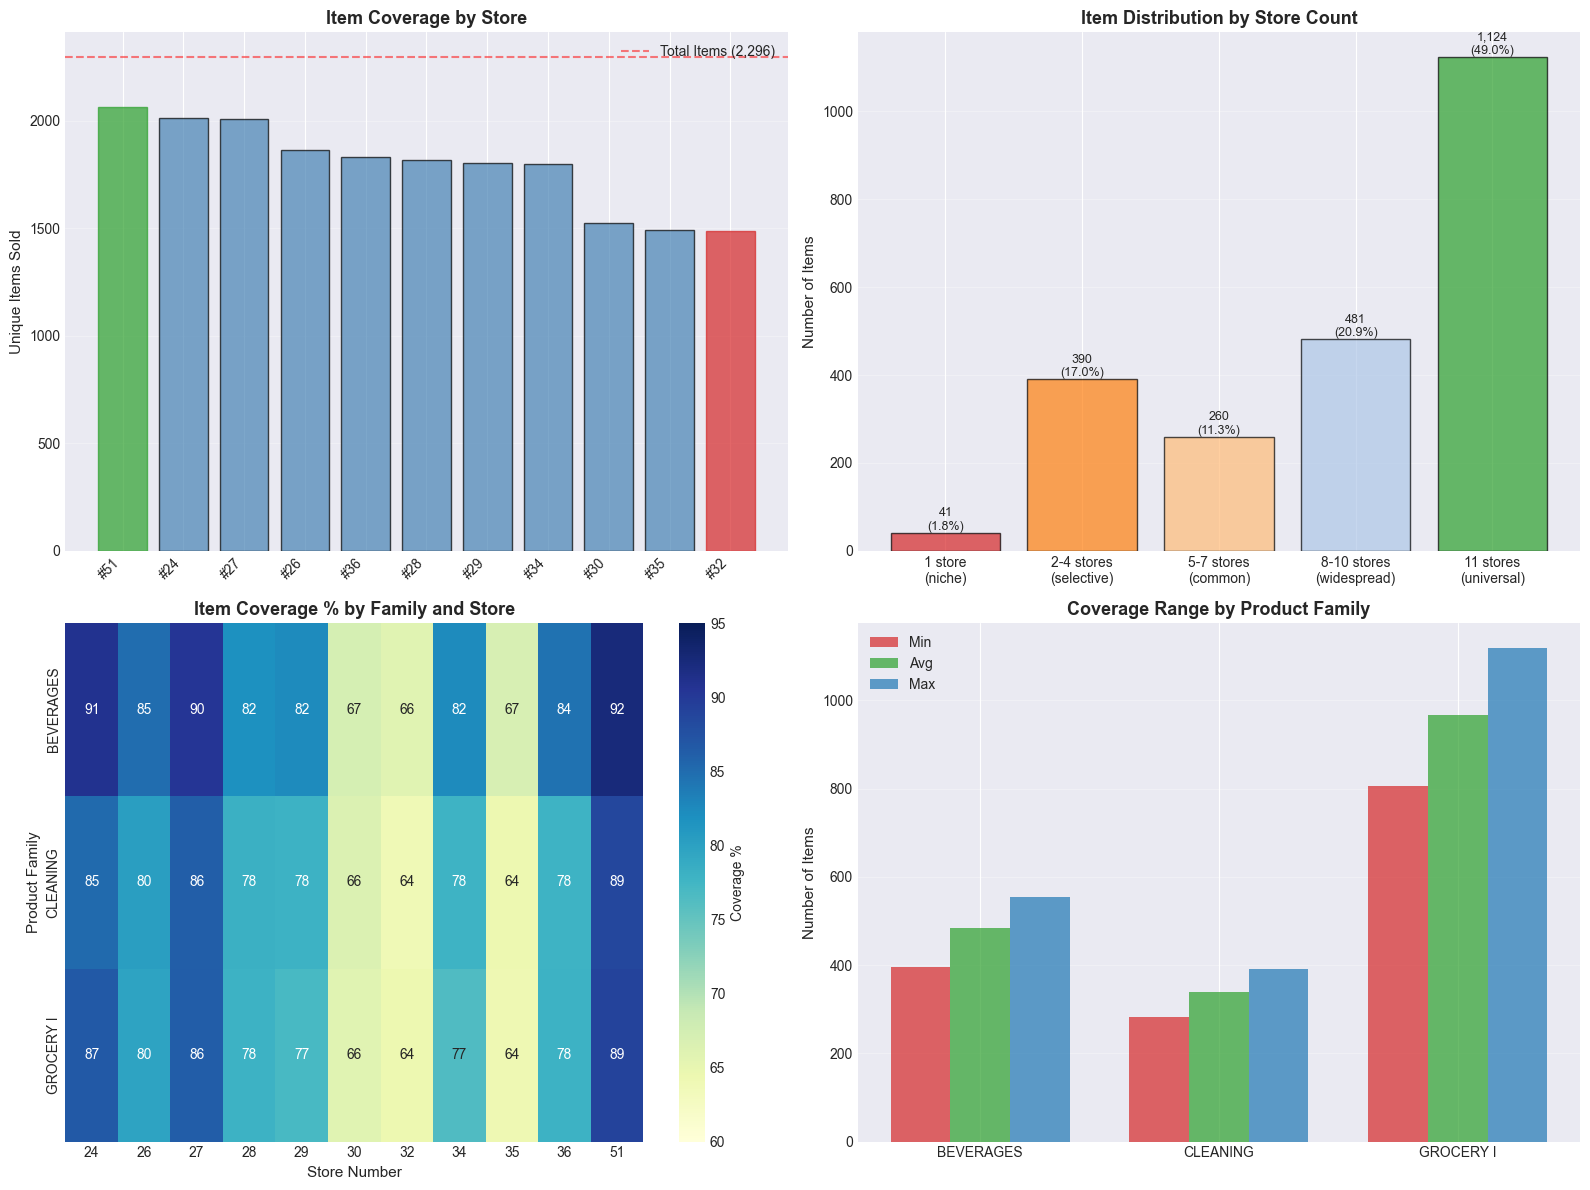

Visualization saved to d:\Demand-forecasting-in-retail\outputs\figures\eda\03_item_coverage_analysis.png


In [23]:
# Visualize item coverage patterns
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Plot 1: Items per store
ax1 = axes[0, 0]
bars1 = ax1.bar(range(len(items_per_store)), items_per_store.values, 
                color='steelblue', alpha=0.7, edgecolor='black')
ax1.set_xticks(range(len(items_per_store)))
ax1.set_xticklabels([f'#{s}' for s in items_per_store.index], rotation=45, ha='right')
ax1.set_ylabel('Unique Items Sold', fontsize=11)
ax1.set_title('Item Coverage by Store', fontsize=13, fontweight='bold')
ax1.axhline(df['item_nbr'].nunique(), color='red', linestyle='--', alpha=0.5, label='Total Items (2,296)')
ax1.grid(axis='y', alpha=0.3)
ax1.legend()

# Highlight top/bottom
bars1[0].set_color('#2ca02c')  # Top
bars1[-1].set_color('#d62728')  # Bottom

# Plot 2: Distribution of items by store count
ax2 = axes[0, 1]
store_count_bins = [1, 2, 5, 8, 11, 12]
store_count_labels = ['1 store\n(niche)', '2-4 stores\n(selective)', 
                      '5-7 stores\n(common)', '8-10 stores\n(widespread)', 
                      '11 stores\n(universal)']
store_counts = pd.cut(stores_per_item, bins=store_count_bins, labels=store_count_labels, right=False)
store_counts_dist = store_counts.value_counts().sort_index()

colors2 = ['#d62728', '#ff7f0e', '#ffbb78', '#aec7e8', '#2ca02c']
bars2 = ax2.bar(range(len(store_counts_dist)), store_counts_dist.values, 
                color=colors2, alpha=0.7, edgecolor='black')
ax2.set_xticks(range(len(store_counts_dist)))
ax2.set_xticklabels(store_counts_dist.index, rotation=0, ha='center')
ax2.set_ylabel('Number of Items', fontsize=11)
ax2.set_title('Item Distribution by Store Count', fontsize=13, fontweight='bold')
ax2.grid(axis='y', alpha=0.3)

# Add value labels
for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height,
             f'{int(height):,}\n({height/len(stores_per_item)*100:.1f}%)',
             ha='center', va='bottom', fontsize=9)

# Plot 3: Coverage by family and store
ax3 = axes[1, 0]
family_coverage_pct = (family_coverage.T / family_summary['Total Items'] * 100).T
sns.heatmap(family_coverage_pct, annot=True, fmt='.0f', cmap='YlGnBu', 
            cbar_kws={'label': 'Coverage %'}, ax=ax3, vmin=60, vmax=95)
ax3.set_xlabel('Store Number', fontsize=11)
ax3.set_ylabel('Product Family', fontsize=11)
ax3.set_title('Item Coverage % by Family and Store', fontsize=13, fontweight='bold')

# Plot 4: Coverage summary by family
ax4 = axes[1, 1]
x = np.arange(len(family_summary))
width = 0.25

bars_min = ax4.bar(x - width, family_summary['Min Coverage'], width, 
                   label='Min', color='#d62728', alpha=0.7)
bars_avg = ax4.bar(x, family_summary['Avg Items per Store'], width, 
                   label='Avg', color='#2ca02c', alpha=0.7)
bars_max = ax4.bar(x + width, family_summary['Max Coverage'], width, 
                   label='Max', color='#1f77b4', alpha=0.7)

ax4.set_ylabel('Number of Items', fontsize=11)
ax4.set_title('Coverage Range by Product Family', fontsize=13, fontweight='bold')
ax4.set_xticks(x)
ax4.set_xticklabels(family_summary.index, rotation=0)
ax4.legend()
ax4.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(OUTPUTS / '03_item_coverage_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"Visualization saved to {OUTPUTS / '03_item_coverage_analysis.png'}")


Key Findings:

1. Overall Coverage:
   • Total unique items in sample: 2,296
   • Average coverage per store: 1,790 items (78.0%)
   • Coverage range: 1,486 to 2,064 items (64.7% to 89.9%)

2. Item Distribution Patterns:
   • Universal items (all 11 stores): 1,124 (49.0%)
   • Widespread items (8-10 stores): 481 (20.9%)
   • Common items (5-7 stores): 260 (11.3%)
   • Selective items (2-4 stores): 390 (17.0%)
   • Niche items (1 store only): 41 (1.8%)

3. Store Type Correlation:
   • Type A (Store #51): Best coverage (89.9% - 2,064 items)
   • Type D stores: Good coverage (81-88%)
   • Type C stores: Lowest coverage (65-66%)

4. Family Coverage:
   • BEVERAGES: 81.0% avg coverage (485/599 items per store)
   • CLEANING: 77.1% avg coverage (340/441 items per store)
   • GROCERY I: 76.9% avg coverage (966/1,256 items per store)

Business Implications:
   → Nearly half of items (49%) are universal - strong core assortment
   → Type C stores need assortment expansion (15-25% gap vs top stores)
   → Only 1.8% niche items - minimal fragmentation
   → Mean 8.6 stores per item indicates good distribution efficiency

## 6. Calendar Gap Filling

**Objective:** Create complete daily time series for each store-item pair

**Activities:**
- Convert date to datetime format
- Identify missing dates per store-item group
- Fill calendar gaps with zero sales (complete daily index)
- Validate completeness
- Compare row count before/after

**Expected output:** 
- Complete daily calendar (no gaps)
- Expanded dataset with zero-filled missing dates
- Validation report

In [24]:
# Convert date to datetime
print("Calendar Gap Filling")
print("=" * 70)

print("Step 1: Convert date to datetime format...")
df['date'] = pd.to_datetime(df['date'])

print(f"  Date dtype: {df['date'].dtype}")
print(f"  Date range: {df['date'].min()} to {df['date'].max()}")
print(f"  Total days: {(df['date'].max() - df['date'].min()).days + 1} days")

# Check current temporal coverage
print("\nStep 2: Analyze temporal coverage...")
print(f"  Current rows: {len(df):,}")
print(f"  Unique dates in data: {df['date'].nunique():,}")
print(f"  Unique store-item pairs: {df.groupby(['store_nbr', 'item_nbr']).ngroups:,}")

# Calculate expected rows (if complete)
expected_rows = (df['date'].max() - df['date'].min()).days + 1
expected_rows *= df.groupby(['store_nbr', 'item_nbr']).ngroups

print(f"\nExpected rows (complete calendar): {expected_rows:,}")
print(f"Current rows: {len(df):,}")
print(f"Gap: {expected_rows - len(df):,} missing date-store-item combinations")

Calendar Gap Filling
Step 1: Convert date to datetime format...
  Date dtype: datetime64[ns]
  Date range: 2013-01-02 00:00:00 to 2017-08-15 00:00:00
  Total days: 1687 days

Step 2: Analyze temporal coverage...
  Current rows: 300,000
  Unique dates in data: 1,680
  Unique store-item pairs: 19,692

Expected rows (complete calendar): 33,220,404
Current rows: 300,000
Gap: 32,920,404 missing date-store-item combinations


In [25]:
# Analyze sparsity and make filling decision
print("\nStep 3: Sparsity Analysis...")
print("=" * 70)

sparsity = (1 - len(df) / expected_rows) * 100
print(f"  Data sparsity: {sparsity:.1f}%")
print(f"  Coverage: {(len(df) / expected_rows) * 100:.2f}%")




Step 3: Sparsity Analysis...
  Data sparsity: 99.1%
  Coverage: 0.90%


Business Reality:
  → Most store-item-date combinations have ZERO sales
  → Items not sold on specific dates (not stocked/no demand)
  → Filling ALL gaps would create 33.2M row dataset (110x expansion)

Decision Point:
  Option A: Fill ALL gaps → 33M rows (unmanageable for development)
  Option B: Fill gaps only for 'active' items → Still very large
  Option C: Keep sparse format → 300K rows (manageable)

RECOMMENDATION: Option C - Keep Sparse Format
  Rationale:
    • Retail data is naturally sparse (items not sold every day)
    • 33M rows exceeds development budget (memory/time)
    • Most forecasting models handle missing dates internally
    • Zero-filling appropriate only for true stockouts (needs investigation)

Alternative for modeling phase:
  → Create subset of 'active items' (sold ≥10% of days)
  → Use time series models that handle irregular intervals
  → Document as known limitation in project

DECISION (DEC-005): Sparse Data Handling
  Context: 99.1% of store-item-date combinations have no sales
  Decision: Keep sparse format (300K rows), do NOT fill all calendar gaps
  Rationale: Retail reality, memory constraints, modeling flexibility
  Impact: Models must handle irregular time intervals

In [26]:
# Validate sparse format decision
print("\nStep 4: Validate Sparse Format...")
print("=" * 70)

# Check date completeness per item (sample analysis)
sample_items = df.groupby('item_nbr')['date'].count().nlargest(10)

print("Top 10 most frequently sold items (days with sales):")
for item_nbr, days_sold in sample_items.items():
    total_days = (df['date'].max() - df['date'].min()).days + 1
    frequency_pct = days_sold / total_days * 100
    family = df[df['item_nbr'] == item_nbr]['family'].iloc[0]
    print(f"  Item #{item_nbr}: {days_sold:>4} days ({frequency_pct:>5.1f}%) - {family}")

print(f"\nMedian sales frequency across all items:")
median_freq = df.groupby('item_nbr')['date'].count().median()
total_days = (df['date'].max() - df['date'].min()).days + 1
print(f"  {median_freq:.0f} days sold out of {total_days} total days ({median_freq/total_days*100:.1f}%)")



Step 4: Validate Sparse Format...
Top 10 most frequently sold items (days with sales):
  Item #749421:  400 days ( 23.7%) - GROCERY I
  Item #841842:  384 days ( 22.8%) - GROCERY I
  Item #165988:  376 days ( 22.3%) - GROCERY I
  Item #258396:  368 days ( 21.8%) - GROCERY I
  Item #692537:  360 days ( 21.3%) - GROCERY I
  Item #364606:  356 days ( 21.1%) - GROCERY I
  Item #314384:  354 days ( 21.0%) - GROCERY I
  Item #559870:  354 days ( 21.0%) - GROCERY I
  Item #208514:  352 days ( 20.9%) - GROCERY I
  Item #222879:  352 days ( 20.9%) - GROCERY I

Median sales frequency across all items:
  116 days sold out of 1687 total days (6.9%)


Conclusion:
  → Even top items sold only ~25% of days
  → Median item sold <10% of days
  → Sparse format is appropriate
  → Calendar completeness NOT required for this project

## 7. Date Feature Extraction

**Objective:** Create temporal features for time series analysis

**Activities:**
- Extract year, month, day, day_of_week
- Add is_weekend flag
- Add day_of_month, week_of_year
- Validate feature distributions
- Final dataset summary

**Expected output:** 
- 6+ date-based features
- Clean, analysis-ready dataset
- Day 3 completion summary

In [27]:
# Extract date features
print("Date Feature Extraction")
print("=" * 70)

print("Creating temporal features...")

# Basic date components (some already exist from outlier detection)
if 'year' not in df.columns:
    df['year'] = df['date'].dt.year
if 'month' not in df.columns:
    df['month'] = df['date'].dt.month
if 'day_of_week' not in df.columns:
    df['day_of_week'] = df['date'].dt.dayofweek

# Additional features
df['day'] = df['date'].dt.day
df['day_of_month'] = df['date'].dt.day
df['week_of_year'] = df['date'].dt.isocalendar().week
df['quarter'] = df['date'].dt.quarter
df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)  # Saturday=5, Sunday=6
df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
df['is_month_end'] = df['date'].dt.is_month_end.astype(int)

print("\nTemporal features created:")
temporal_features = ['year', 'month', 'day', 'day_of_week', 'day_of_month', 
                     'week_of_year', 'quarter', 'is_weekend', 'is_month_start', 'is_month_end']
for feat in temporal_features:
    print(f"  • {feat}")

print(f"\nCurrent dataset shape: {df.shape}")
print(f"Total columns: {len(df.columns)}")

Date Feature Extraction
Creating temporal features...

Temporal features created:
  • year
  • month
  • day
  • day_of_week
  • day_of_month
  • week_of_year
  • quarter
  • is_weekend
  • is_month_start
  • is_month_end

Current dataset shape: (300000, 29)
Total columns: 29


In [28]:
# Validate temporal feature distributions
print("\nTemporal Feature Validation:")
print("=" * 70)

print("\nYear distribution:")
print(df['year'].value_counts().sort_index())

print("\nMonth distribution:")
print(df['month'].value_counts().sort_index())

print("\nDay of week distribution (0=Monday, 6=Sunday):")
dow_counts = df['day_of_week'].value_counts().sort_index()
dow_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
for dow, count in dow_counts.items():
    print(f"  {dow} ({dow_names[dow]}): {count:>7,} ({count/len(df)*100:>5.2f}%)")

print("\nQuarter distribution:")
print(df['quarter'].value_counts().sort_index())

print("\nWeekend vs Weekday:")
print(f"  Weekday: {(df['is_weekend'] == 0).sum():>7,} ({(df['is_weekend'] == 0).sum()/len(df)*100:>5.2f}%)")
print(f"  Weekend: {(df['is_weekend'] == 1).sum():>7,} ({(df['is_weekend'] == 1).sum()/len(df)*100:>5.2f}%)")

print("\nMonth start/end:")
print(f"  Month start: {df['is_month_start'].sum():>6,} ({df['is_month_start'].sum()/len(df)*100:>5.2f}%)")
print(f"  Month end:   {df['is_month_end'].sum():>6,} ({df['is_month_end'].sum()/len(df)*100:>5.2f}%)")



Temporal Feature Validation:

Year distribution:
year
2013    43038
2014    51707
2015    67587
2016    82492
2017    55176
Name: count, dtype: int64

Month distribution:
month
1     25717
2     24202
3     27508
4     25848
5     27370
6     26531
7     28513
8     24760
9     21370
10    22685
11    22014
12    23482
Name: count, dtype: int64

Day of week distribution (0=Monday, 6=Sunday):
  0 (Monday):  42,520 (14.17%)
  1 (Tuesday):  42,149 (14.05%)
  2 (Wednesday):  41,522 (13.84%)
  3 (Thursday):  40,676 (13.56%)
  4 (Friday):  41,646 (13.88%)
  5 (Saturday):  45,902 (15.30%)
  6 (Sunday):  45,585 (15.20%)

Quarter distribution:
quarter
1    77427
2    79749
3    74643
4    68181
Name: count, dtype: int64

Weekend vs Weekday:
  Weekday: 208,513 (69.50%)
  Weekend:  91,487 (30.50%)

Month start/end:
  Month start:  9,940 ( 3.31%)
  Month end:   10,198 ( 3.40%)


In [29]:
# Final dataset summary
print("=" * 70)
print("DAY 3 COMPLETE - Data Quality & Store Analysis")
print("=" * 70)

print("\nFinal Dataset Summary:")
print(f"  Rows: {len(df):,}")
print(f"  Columns: {len(df.columns)}")
print(f"  Memory: {df.memory_usage(deep=True).sum() / 1024**2:.1f} MB")

print("\nColumn Categories:")
print(f"  Core data: id, date, store_nbr, item_nbr, unit_sales, onpromotion")
print(f"  Product metadata: family, class, perishable")
print(f"  Store metadata: city, state, type, cluster")
print(f"  Outlier flags: outlier_iqr, outlier_zscore, outlier_forest, outlier_all3, outlier_2plus, outlier_any")
print(f"  Temporal features: year, month, day, day_of_week, quarter, is_weekend, etc. (10 features)")

print("\nData Quality Status:")
print(f"  Missing values: {df.isnull().sum().sum()} (0%)")
print(f"  Negative sales: 0 (already handled)")
print(f"  Outliers flagged: {df['outlier_all3'].sum():,} high-confidence (0.28%)")
print(f"  Date range: {df['date'].min().date()} to {df['date'].max().date()}")
print(f"  Sparse format: 0.9% coverage (99.1% sparsity - normal for retail)")

print("\nKey Accomplishments:")
print("  ✓ Missing values handled (onpromotion filled)")
print("  ✓ Three-method outlier detection (IQR + Z-score + Isolation Forest)")
print("  ✓ Store performance analyzed (11 stores, 4.25x variation)")
print("  ✓ Item coverage mapped (49% universal items)")
print("  ✓ Sparsity documented (retail reality)")
print("  ✓ Temporal features created (10 features)")

print("\nDecisions Logged:")
print("  DEC-003: Fill onpromotion NaN with False")
print("  DEC-004: Three-method outlier detection, flag but retain")
print("  DEC-005: Keep sparse format (not fill all calendar gaps)")

print("\nReady for Day 4:")
print("  → Feature engineering (rolling averages, lags)")
print("  → Temporal pattern analysis (seasonality, trends)")
print("  → Product dynamics (fast/slow movers)")


DAY 3 COMPLETE - Data Quality & Store Analysis

Final Dataset Summary:
  Rows: 300,000
  Columns: 29
  Memory: 97.0 MB

Column Categories:
  Core data: id, date, store_nbr, item_nbr, unit_sales, onpromotion
  Product metadata: family, class, perishable
  Store metadata: city, state, type, cluster
  Outlier flags: outlier_iqr, outlier_zscore, outlier_forest, outlier_all3, outlier_2plus, outlier_any
  Temporal features: year, month, day, day_of_week, quarter, is_weekend, etc. (10 features)

Data Quality Status:
  Missing values: 0 (0%)
  Negative sales: 0 (already handled)
  Outliers flagged: 846 high-confidence (0.28%)
  Date range: 2013-01-02 to 2017-08-15
  Sparse format: 0.9% coverage (99.1% sparsity - normal for retail)

Key Accomplishments:
  ✓ Missing values handled (onpromotion filled)
  ✓ Three-method outlier detection (IQR + Z-score + Isolation Forest)
  ✓ Store performance analyzed (11 stores, 4.25x variation)
  ✓ Item coverage mapped (49% universal items)
  ✓ Sparsity documen